## Practice dataset: Airlines Arrival


Dataset found here: http://stat-computing.org/dataexpo/2009/the-data.html   
I am using the dataset for 2008. 

Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

Primary question: 
- Outcome of interest: Whether an arriving flight will be on time or delayed. 


Secondary outcomes: 
- When is a good time to fly or when flights are least delayed? 
- List of  airlines that are more prone to delay? 
- What are the primary factors that cause/ related to delay? 

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import sklearn models 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

# Time 
from time import time


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('2008.csv')

In [3]:
df.shape # 7 mln datapoints, 29 variables including the outcome variable
#random sampling to 25% for computational efficiency

(7009728, 29)

In [4]:
sample = df.sample(frac=0.25, replace=True, random_state=111)

In [5]:
sample.shape  # 1.75 mln datapoints, 29 variables

(1752432, 29)

In [111]:
sample.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3616596,2008,7,6,7,649.0,655,807.0,815,WN,468,...,8.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6945644,2008,12,7,7,834.0,835,1403.0,1430,AS,20,...,6.0,18.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4728788,2008,8,4,1,1954.0,1715,129.0,2250,AA,794,...,8.0,25.0,0,NaN,0,0.0,0.0,2.0,0.0,157.0
4330196,2008,8,18,1,1326.0,1335,1427.0,1442,XE,430,...,4.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2199638,2008,4,24,4,2017.0,1910,2209.0,2055,MQ,4502,...,5.0,22.0,0,NaN,0,36.0,0.0,7.0,0.0,31.0


In [112]:
sample.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1752432.0,1.752432e+06,1.752432e+06,1.752432e+06,1.718472e+06,1.752432e+06,1.714614e+06,1.752432e+06,1.752432e+06,1.713870e+06,...,1.752432e+06,1.714614e+06,1.718263e+06,1.752432e+06,1.752432e+06,380791.000000,380791.000000,380791.000000,380791.000000,380791.000000
mean,2008.0,6.377964e+00,1.573477e+01,3.924709e+00,1.333708e+03,1.326068e+03,1.481187e+03,1.494558e+03,2.224662e+03,1.272535e+02,...,7.258026e+02,6.859805e+00,1.644132e+01,1.955568e-02,2.449168e-03,15.834156,3.048412,17.235055,0.071422,20.729319
std,0.0,3.407132e+00,8.795838e+00,1.989233e+00,4.781821e+02,4.642054e+02,5.050018e+02,4.824917e+02,1.961511e+03,7.014678e+01,...,5.616410e+02,4.930965e+00,1.133278e+01,1.384676e-01,4.942844e-02,39.950477,19.148238,32.173666,1.887592,39.117848
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.600000e+01,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,9.280000e+02,9.250000e+02,1.107000e+03,1.115000e+03,6.220000e+02,7.700000e+01,...,3.250000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.320000e+03,1.512000e+03,1.517000e+03,1.571000e+03,1.090000e+02,...,5.800000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,6.000000,0.000000,0.000000
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.728000e+03,1.715000e+03,1.909000e+03,1.906000e+03,3.518000e+03,1.570000e+02,...,9.510000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,16.000000,0.000000,21.000000,0.000000,26.000000
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.741000e+03,1.379000e+03,...,4.962000e+03,2.330000e+02,4.290000e+02,1.000000e+00,1.000000e+00,1552.000000,1148.000000,1357.000000,392.000000,925.000000


In [345]:
sample.columns #'ArrDelay' is the variable of interest, value in minutes

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [6]:
sample.ArrDelay.describe()

count    1.713870e+06
mean     8.169415e+00
std      3.843001e+01
min     -8.700000e+01
25%     -1.000000e+01
50%     -2.000000e+00
75%      1.200000e+01
max      1.583000e+03
Name: ArrDelay, dtype: float64

In [7]:
# sns.distplot(sample.ArrDelay) # column has null values 

# All flights that are cancelled or diverted had null values, but with selecting the subset above the null values are averted. 
# No delayed flights were cancelled or diverted
sample.groupby(['Cancelled', 'Diverted'])['ArrDelay'].describe()


count      mean        std   min   25%  50%   75%  \
Cancelled Diverted                                                          
0         0         1713870.0  8.169415  38.430009 -87.0 -10.0 -2.0  12.0   
          1               0.0       NaN        NaN   NaN   NaN  NaN   NaN   
1         0               0.0       NaN        NaN   NaN   NaN  NaN   NaN   

                       max  
Cancelled Diverted          
0         0         1583.0  
          1            NaN  
1         0            NaN

In [8]:
# Dropping rows of 'Cancelled' and 'Diverted' flights
sample = sample[(sample.Cancelled==0) & (sample.Diverted==0)]

In [9]:
sample.ArrDelay.isnull().sum()  

sample.isnull().sum() #now no null values for Arrival Delay. Bunch of null values for different delays as there were 0 delays. 

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    0
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode     1713870
Diverted                   0
CarrierDelay         1333079
WeatherDelay         1333079
NASDelay             1333079
SecurityDelay        1333079
LateAircraftDelay    1333079
dtype: int64

In [28]:
sample.ArrDelay.mean()

8.169415416571852

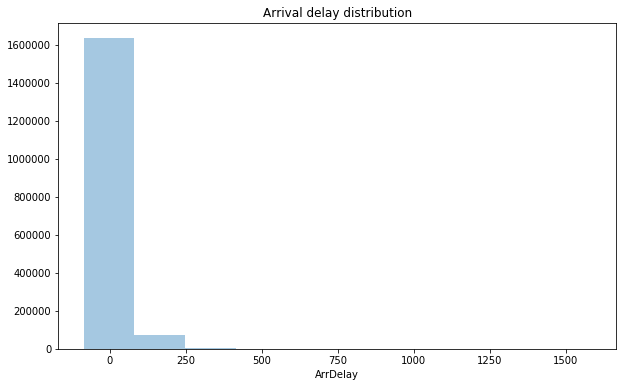

In [30]:
plt.figure(figsize=(10,6))
sns.distplot(sample.ArrDelay, bins=10, kde=False)
plt.title('Arrival delay distribution')
plt.show()

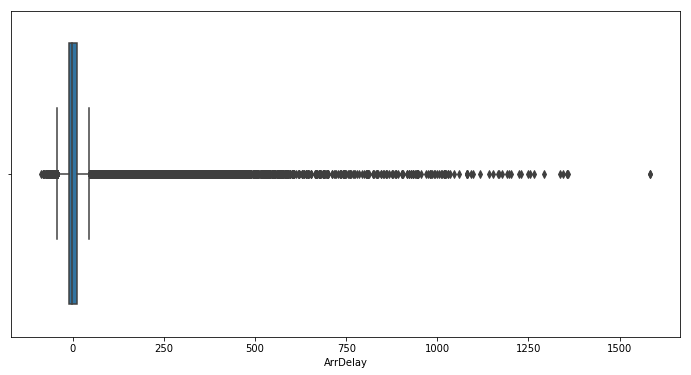

In [37]:
plt.figure(figsize=(12,6))
sns.boxplot(sample.ArrDelay)
plt.show()


# Mostly normally distributed. Most delays are within the first 50 minutes. 
# Any delay more than one day (1440 mins) is unlikely and has special circumstances. Outlier. 

## Exploratory Data Analysis and Visualizations

Let's take a look at how arrival delay is related to other variables. 

- First let's take a look at how months and days are related to arrival delay. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


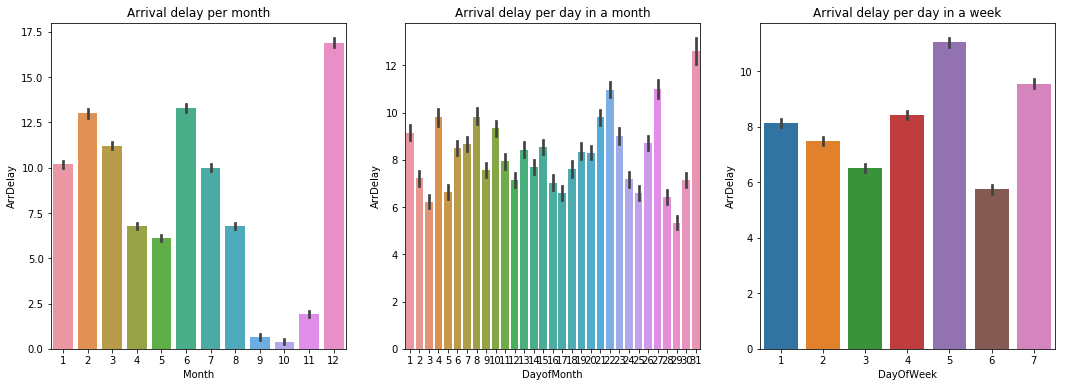

In [353]:
# Arrival delay and time

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.barplot(data=sample, x='Month', y='ArrDelay')
plt.title('Arrival delay per month')

plt.subplot(1,3,2)
sns.barplot(data=sample, x='DayofMonth', y='ArrDelay')
plt.title('Arrival delay per day in a month')


plt.subplot(1,3,3)
sns.barplot(data=sample, x='DayOfWeek', y='ArrDelay')
plt.title('Arrival delay per day in a week')
plt.show()


### Summary: 

- Flights in December are delayed the most, while flights in September, October and November are generally delayed less. 

- Days are not a good indicator of arrival delay, although in a week, Friday and Sunday (assuming week starts with Monday) seem to have consistent delay. 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


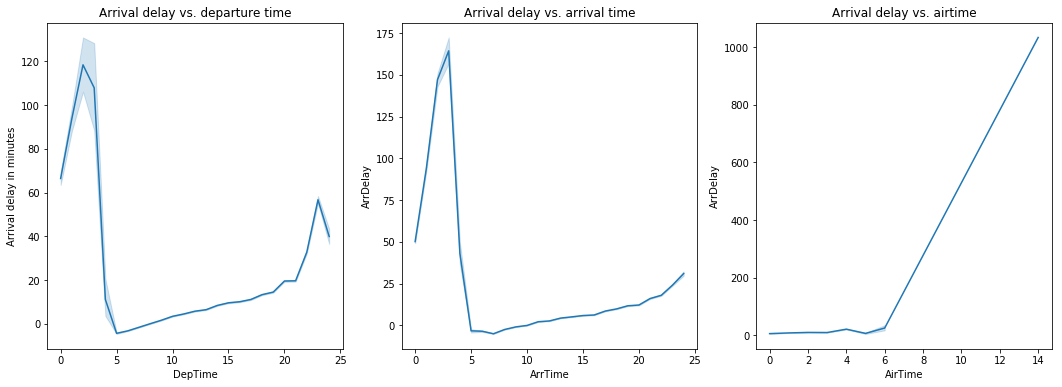

In [382]:
# Arrival delay and time

plt.figure(figsize=(18,6))


plt.subplot(1,3,1)
# DepTime in hhmm format, divided by 100 and rounded to 0 to extract the hours.
sns.lineplot(x=round(sample.DepTime/100, 0), y=sample.ArrDelay, markers=True) 
plt.ylabel('Arrival delay in minutes')
plt.title('Arrival delay vs. departure time')


plt.subplot(1,3,2)
sns.lineplot(x=round(sample.ArrTime /100, 0), y=sample.ArrDelay, markers=True)
plt.title('Arrival delay vs. arrival time')


plt.subplot(1,3,3)
sns.lineplot(x=round(sample.AirTime/100, 0), y=sample.ArrDelay, markers=True)
plt.title('Arrival delay vs. airtime')
plt.show()


### Summary: 

- Flights departing and arriving between midnight and 5 am are delayed the most. 

- Flights with longer than 6 hours of airtime also arrived delayed. The longer the airtime, longer is the propensity of the delay. 

#### Let's now see how other types of delays are related to arrival delay 

In [ ]:
#sample.columns

In [383]:
# Creating a subset of all types of delays to check the relation among arrival and other types of delays. 
delay_variables = sample[['ArrDelay','DepDelay', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]

In [384]:
delay_variables.isnull().sum() # 36k null values, no delay = 0 delay, filling the null values with 0

delay_variables = delay_variables.fillna(0)

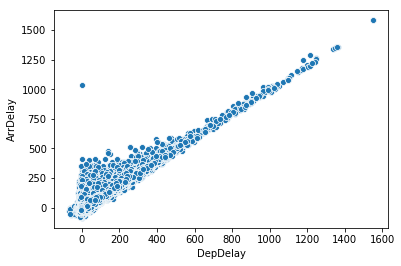

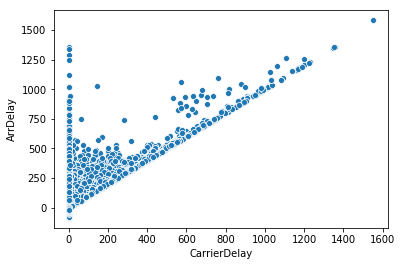

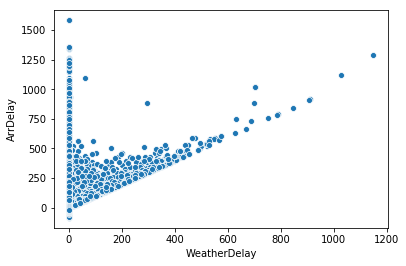

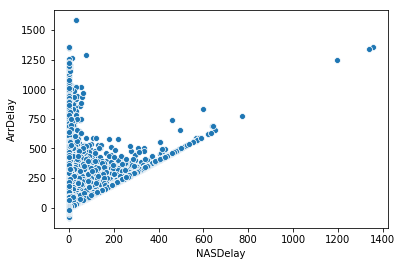

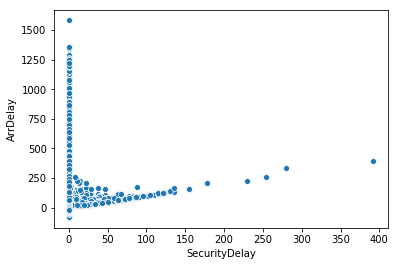

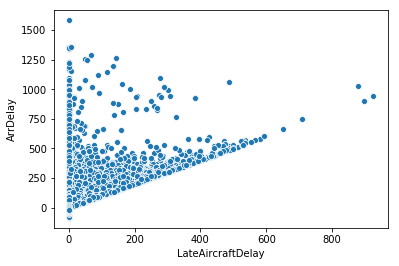

In [385]:
for col in delay_variables.columns[1:]:
 #   print(col)
    sns.scatterplot(data=delay_variables, y='ArrDelay', x=col)
    plt.show()
    


### Summary: 

- All types of delays positively affect arrival delay. 
- DepDelay has a linear relation with arrival delay indicating is a flight is departed late, it is most certainly going to be arriving late. 
- CarrierDelay and LateAircraftDelay also cause arrival delay. However, other types of delays do not significantly affect arrival delay. 

#### Let's now check if there are any airport or carrier that are associated with delays. 

In [131]:
# Reassigning delay_Variables
#delay_variables = sample[['ArrDelay','DepDelay', 'CarrierDelay','LateAircraftDelay']]

In [52]:
#delay_variablesq = delay_variables.fillna(0)  # fill missing delay variables with 0 as 
# missing delay value = no delay = 0 delay 

In [132]:
##plt.figure(figsize=(12,8))
#
##Declare scatterplot matrix
#g = sns.PairGrid(delay_variablesq, diag_sharey=False)
#
##Set upper matrix to scatter
#g.map_upper(plt.scatter, alpha=.5)
#
##Set lower matrix to regression lines
#g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
#
##Set diagonals to distribution plot
#g.map_diag(sns.distplot)
#plt.show()

In [390]:
# Selecting a subset with arrival delay wrt carrier, origin and destination
sample_1 = sample[['ArrDelay', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest']]

# Selecting only positive delays, not early arrivals (in negative values)
sample_1 = sample_1[sample_1.ArrDelay >= 0]

In [391]:
sample_1.head()

,ArrDelay,UniqueCarrier,FlightNum,TailNum,Origin,Dest
4728788,159.0,AA,794,N4WPAA,LAS,ORD
2199638,74.0,MQ,4502,N626AE,ORD,AZO
1732726,51.0,B6,87,N651JB,JFK,SLC
3905490,51.0,US,1712,N713UW,FLL,DCA
168903,20.0,OH,5360,N786CA,ORD,JFK


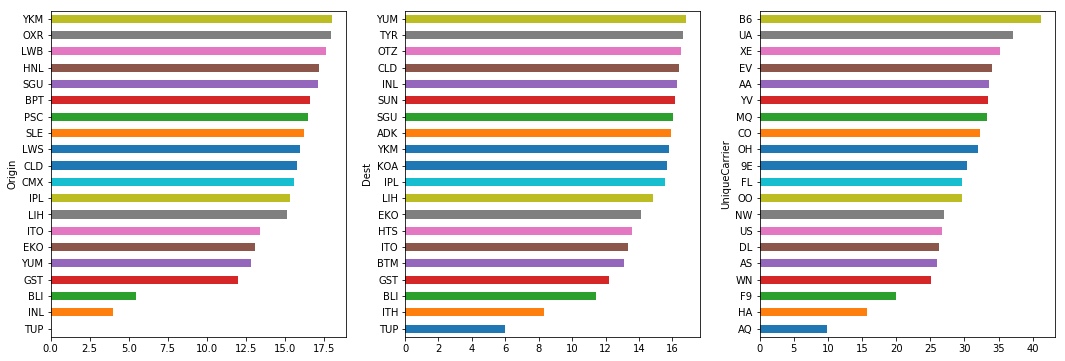

In [400]:
# Top 20 delay values for origin airport, destination airport and unique carrier. 

plt.figure(figsize=(18,6))

for col, subplt in zip(['Origin', 'Dest', 'UniqueCarrier'], [1,2,3]):
    plt.subplot(1,3, subplt)
    sample_1.groupby([col])['ArrDelay'].mean().sort_values(ascending=True).head(20).plot(kind='barh')
plt.show()

#### Summary: 

- None of the big airports are consistently delayed for departure or arrival, except for St. George Airport in Washington State. 

- Jetblue (B6) carrier has the most amount of delays. 

In [401]:
# Airport traffic

(sample.groupby(['Origin'])['DayofMonth'].count()/30).sort_values(ascending=False).head()

Origin
ATL    3388.433333
ORD    2800.566667
DFW    2273.533333
DEN    1985.633333
LAX    1757.600000
Name: DayofMonth, dtype: float64

Text(0.5,0,'Number of flights arriving everyday')

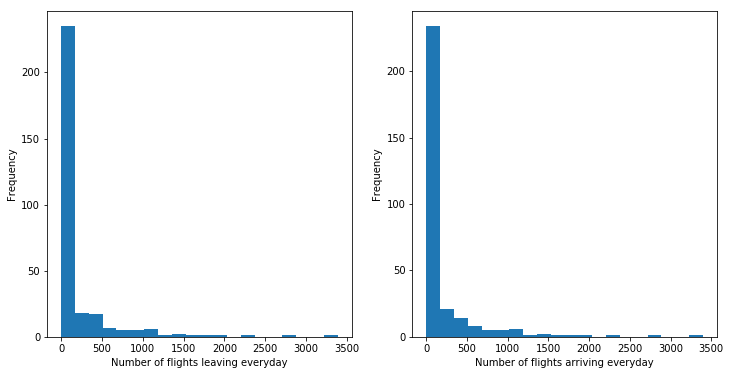

In [402]:
# How many flights per each airport 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
(sample.groupby(['Origin'])['DayofMonth'].count()/30).plot(kind='hist', bins=20)
plt.xlabel('Number of flights leaving everyday')

plt.subplot(1,2,2)
(sample.groupby(['Dest'])['DayofMonth'].count()/30).plot(kind='hist', bins=20)
plt.xlabel('Number of flights arriving everyday')
# There is a large number of airports where small numbers of flights operate everyday.

# These are probably the same airports and we can create a few feature in terms of airport traffic.

In [403]:
# select a subset of columns - removing features that are not relevant

sample = sample.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], 
                    axis=1)


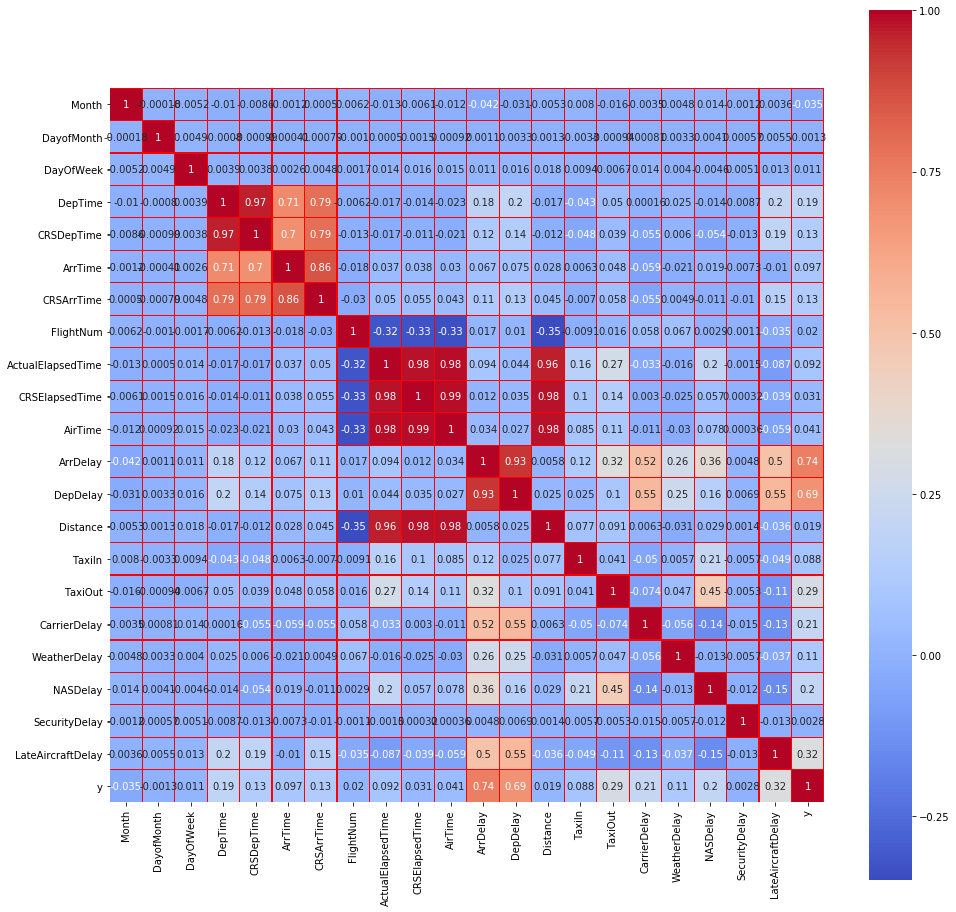

In [404]:
# Let's look at the correlations among the variables

plt.figure(figsize=(16,16))
sns.heatmap(sample.corr(), cmap='coolwarm', square=True, annot=True, 
            linecolor='red', vmax=1, linewidth=.1)

#### Feature correlation summary

- Arrival delay is highly correlated with departure delay (expected). 
- All respective CRS values are highly correlated with actual/realtime values.  
- Distance is higly correlated with Elapsed time and air time.



## Running models to see the baseline accuracy

In [38]:
# creating the y variable for classification. 
# Required criterion: A flight only counts as late if it is more than 30 minutes late.

sample['y'] = np.where(sample['ArrDelay']>30, 1, 0)

In [39]:
# Creating X and y

X = sample.drop(['ArrDelay','y'], axis=1)
y = sample.y

In [42]:
# checking for null values 
X.isnull().sum()

# All delay values have same null values, filling those with 0 as no delay = 0 delay 
X = X.fillna(0)

In [408]:
# Checking null values again 
#X.isnull().sum()

In [44]:
# Also checking for string values - Unique Carrier, TailNum, Origin and Destination are string values 
X.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode       int64
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [46]:
X.UniqueCarrier.describe() # 20 unique values
X.Dest.describe() # 302 unique values 
X.Origin.describe() # 302 unique values 
X.TailNum.describe() #5339 unique values 
## Drop these variables as (1) contain strings, (2) too many unique values for dummy variable. 

# dropping except for UniqueCarrier, which has 20 values and may be worth dummying
X = X.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)

In [47]:
# train test split 
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=.3, random_state=101)

In [49]:
X_tr.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn',
       'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [50]:
X_tr.shape
y_tr.shape
X_ts.shape
y_ts.shape

(514161,)

In [54]:
# Class imbalance

print('Values of y: \n', y_tr.value_counts())
print('% of late arrival: ',round(len(y_tr[y_tr==1])/len(y_tr),2))

# 13% is imbalanced data. Resampling required. 


Values of y: 
 0    1042199
1     157510
Name: y, dtype: int64
% of late arrival:  0.13


In [55]:
# Running Random Forest classifier to check baseline accuracy. Data has some high correlation, expecting high accuracy due to overfitting. 

start = time()
# Trying Random Forest 
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(X_tr, y_tr)
score = rfc.score(X_ts, y_ts)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 0.9966703036597486
Elapsed time: 40 seconds


In [56]:
start = time()
score = cross_val_score(rfc, X_tr, y_tr, cv=5)
print('5-fold Crossvalidated accuracy: ', score.mean())
print('with standard deviation: ',score.std())
print('Elapsed time: ', time() - start)

5-fold Crossvalidated accuracy:  0.996356616685142
with standard deviation:  0.0003395383086327187
Elapsed time:  155.9196650981903


In [427]:
# Accuracy score 99.6% - overfitting

In [58]:
sample.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'y'],
      dtype='object')

In [87]:
X.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn',
       'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [59]:
# Class imbalance

print('Values of y: \n', y_tr.value_counts())
print('% of late arrival: ',round(len(y_tr[y_tr==1])/len(y_tr),2))

# 13% is imbalanced data. Resampling required. 

Values of y: 
 0    1042199
1     157510
Name: y, dtype: int64
% of late arrival:  0.13


In [88]:
sample.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'y'],
      dtype='object')

In [89]:
# Resampling for class imbalance 
# Trying downsampling the majority class as we have enough data points. 
# Code from https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
sample_majority = sample[y==0]
sample_minority = sample[y==1]


print(sample_majority.shape)
print(sample_minority.shape)



(1488625, 30)
(225245, 30)


In [90]:
 # Downsample majority class
sample_majority_downsampled = resample(sample_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=225245,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
sample_balanced = pd.concat([sample_majority_downsampled, sample_minority])
 

In [91]:
print(sample_balanced.y.value_counts())

1    225245
0    225245
Name: y, dtype: int64


In [107]:
sample_balanced.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'y'],
      dtype='object')

In [108]:
X_balanced = sample_balanced.drop(['Year','CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'Cancelled', 
                          'CancellationCode', 'Diverted', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest',
                          'AirTime', 'Distance', 'ArrDelay', 'y'], axis=1)

In [109]:
#X_balanced = X_balanced.drop(['Origin', 'Dest'], axis=1)

In [110]:
X_balanced.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'ArrTime',
       'ActualElapsedTime', 'DepDelay', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [111]:
y_b = sample_balanced.y

In [113]:
y_b.shape

(450490,)

In [105]:

# All delay values have same null values, filling those with 0 as no delay = 0 delay 
X_balanced = X.fillna(0)

# Checking null values again 
X_balanced.isnull().sum()

# Also checking for string values - Unique Carrier, TailNum, Origin and Destination are string values 
X_balanced.dtypes

#X.UniqueCarrier.describe() # 20 unique values
#X.Dest.describe() # 302 unique values 
#X.Origin.describe() # 302 unique values 
#X.TailNum.describe() #5339 unique values 
### Drop these variables as (1) contain strings, (2) too many unique values for dummy variable. 
#
## dropping except for UniqueCarrier, which has 20 values and may be worth dummying
#X = X.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)
#


Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
FlightNum              int64
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
DepDelay             float64
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode       int64
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [114]:
# train test split 
Xb_tr, Xb_ts, yb_tr, yb_ts = train_test_split(X_balanced, y_b, test_size=.3, random_state=101)

In [121]:
Xb_tr = Xb_tr.dropna()

In [122]:
# Trying Random Forest again 

start = time()
# Trying Random Forest 
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(Xb_tr, yb_tr)
score = rfc.score(Xb_ts, yb_ts)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")


ValueError: Number of labels=315343 does not match number of samples=173927

In [84]:
start = time()
score = cross_val_score(rfc, X_tr_balanced, y_tr, cv=5)
print('5-fold Crossvalidated accuracy: ', score.mean())
print('with standard deviation: ',score.std())
print('Elapsed time: ', time() - start)

ValueError: Found input variables with inconsistent numbers of samples: [315020, 1199709]

In [429]:
start = time()
roc_auc_scores = []
parameters = []

est_number = [10, 50,70, 100] 

for value in est_number:
    rfc = RandomForestClassifier(n_jobs = -1, n_estimators = value)
    roc_auc = np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'roc_auc', n_jobs=-1))
    roc_auc_scores.append(roc_auc)
    parameters.append(value)
print('Elapsed time:', time()-start)

KeyboardInterrupt: 

In [ ]:

rac = pd.DataFrame(roc_auc_scores)
rac['params'] = parameters
rac.columns=['roc_auc_scores', 'params']

rac.sort_values(by = 'roc_auc_scores', ascending=False).reset_index(drop=True)

# Still overfitting. 
#Let's get on to feature selection and feature engineering.

In [222]:
sample.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'y'],
      dtype='object')

In [238]:
#sample[['UniqueCarrier', 'FlightNum', 'Distance']].groupby(['UniqueCarrier','FlightNum']).values()

### Feature Selection 

If the task is to predict the arrival delay in advance, certain features (e.g., delay, actual times) won't be useful as they are added posthoc. For example, aircraftdelay or elapsed airtime values won't be available to the model. Instead, all CRS features will be usefulfor the closest approximation. For a more appropriate set of features used for prediction, let's drop the following features:  

'DepTime','ActualElapsedTime', 'ArrDelay','DepDelay', 'TaxiIn', 'TaxiOut','CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'

Additionally, distance, airtime and elapsed time were highly correlated. Drop 

Possible new features: 
depending on how busy the airport is 

In [369]:
sample_new = sample.drop(['DepTime', 'ArrTime','ActualElapsedTime', 'AirTime',
       'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'y', 'orign_traffic', 'dest_traffic'], axis=1)

KeyError: "['orign_traffic' 'dest_traffic'] not found in axis"

In [310]:
sample_new.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'CRSElapsedTime', 'ArrDelay',
       'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut'],
      dtype='object')

In [311]:
Origin_traffic = sample.groupby(['Origin'])['DayofMonth'].count()/30

#sample['Origin_traffic'] = sample.groupby(['Origin'])['DayofMonth'].count()/30
#Origin_traffic

In [312]:
for airport in Origin_traffic.index:
    if airport in sample_new.Origin:
        print(Origin_traffic[airport])
        sample_new.arrTraffic.append(Origin_traffic[airport])

In [342]:
sample_new['arrTraffic'] = pd.DataFrame

In [314]:
Dest_traffic = sample.groupby(['Dest'])['DayofMonth'].count()/30

In [315]:
#plt.figure(figsize=(16,16))
#sns.heatmap(sample.corr(), cmap='coolwarm', square=True, annot=True, 
#            linecolor='red', vmax=1, linewidth=.1)

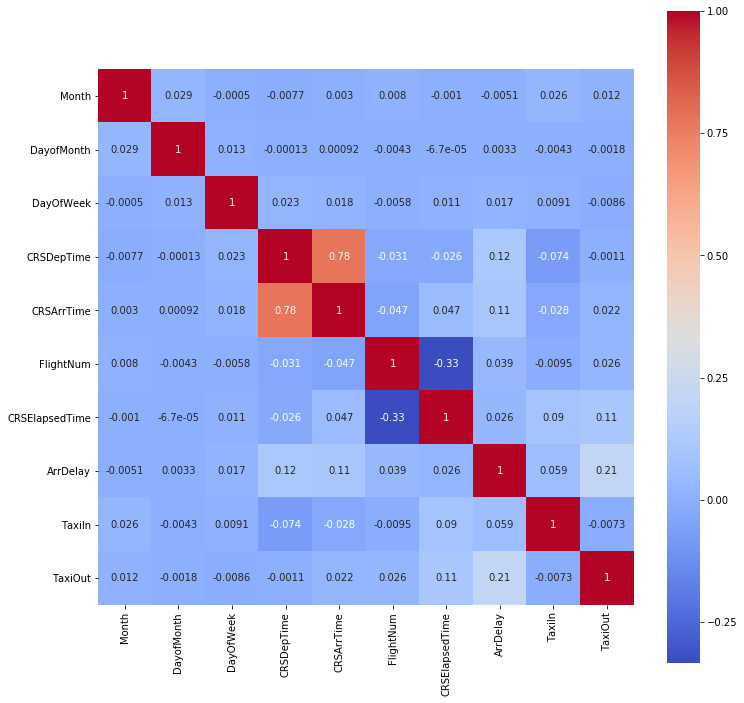

In [318]:
plt.figure(figsize=(12,12))
sns.heatmap(sample_new.corr(), cmap='coolwarm', square=True, annot=True)

In [317]:
sample_new = sample_new.drop('Distance', axis=1)

In [319]:
# creating the y variable for classification. 
# Required criterion: A flight only counts as late if it is more than 30 minutes late.

sample_new['y'] = np.where(sample_new['ArrDelay']>30, 1, 0)

# Creating X and y

X = sample_new.drop('y', axis=1)
y = sample_new.y

# checking for null values 



In [321]:
X.isnull().sum()

# train test split 
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=.3, random_state=101)

In [325]:
# dropping except for UniqueCarrier, which has 20 values and may be worth dummying
X_tr = X_tr.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)
X_ts = X_ts.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)

In [326]:
start = time()
# Trying Random Forest 
rfc = RandomForestClassifier(n_estimators=3)
rfc.fit(X_tr, y_tr)
score = rfc.score(X_ts, y_ts)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 1.0
Elapsed time: 3 seconds


In [328]:
lr = LogisticRegression(C=1e9)
fit = lr.fit(X_tr, y_tr)

In [330]:
# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y = lr.predict(X_ts)

print('\n Accuracy')
print(pd.crosstab(pred_y, y_ts))

print('\n Percentage accuracy')
print(lr.score(X_tr, y_tr))

Coefficients
[[-5.27052239e-02 -2.42045240e-02 -1.09136129e-01 -5.85305135e-04
  -4.69773362e-04 -1.35449322e-04 -4.20550251e-03  4.90758588e-01
  -2.53643046e-02 -1.18379804e-02]]
[-10.99020493]

 Accuracy
y           0      1
row_0               
0      154831   1145
1        1020  66350

 Percentage accuracy
0.9906934439630194


In [331]:
GBC = GradientBoostingClassifier()
GBC.fit(X_tr, y_tr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [334]:
# Display.
pred_y = GBC.predict(X_ts)

print('\n Accuracy')
print(pd.crosstab(pred_y, y_ts))

print('\n Percentage accuracy')
print(GBC.score(X_tr, y_tr))


 Accuracy
y           0      1
row_0               
0      155851      0
1           0  67495

 Percentage accuracy
1.0


In [335]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [336]:
neighbors.fit(X_tr, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [337]:
y_pred = neighbors.predict(X_ts)

In [338]:
print(pd.crosstab(y_pred, y_ts))

y           0      1
row_0               
0      154123  12602
1        1728  54893


In [339]:
print('\n Percentage accuracy')
print(neighbors.score(X_tr, y_tr))


 Percentage accuracy
1.0
